# Integrating bulk and single-cell patient-derived AML RNA-seq data 

Andrew Ashford, Pathways + Omics Group - OHSU, 5/24/2024

The goal of this Jupyter Notebook will be to integrate (standardize) bulk and single-cell patient-derived AML RNA-seq data. I will be using the Beat AML cohort from OHSU as the bulk RNA-seq data and the scRNA-data from vanGalen et al., 2019. The end-goal of this process will be to use the bulk RNA-seq data with its joint mutation status to train classification models to determine the presence or absence of specific cancer-associated gene mutations using just the transcript data. I will then apply the trained model to scRNA-seq data which has the patient's mutation status that the samples were derived.

#### Import modules

In [1]:
# Import modules
import scanpy as sc
import pandas as pd
import harmonypy as hm
import sys
from scipy.io import mmread

# Import custom modules
sys.path.append('../')
from scOPE import preprocessing


#### Read in bulk RNA-seq data

In [2]:
# Specify directory and filename of the Beat AML bulk RNA-seq data
# NOTE: I'm using the raw counts for this step
counts_dir = '/Users/hamiltsy/Documents/GitLab/Mutation/beatAML_data/'
counts_filename = 'beataml_waves1to4_counts_dbgap.txt'


In [3]:
# Load the data using custom preprocessing module
counts_df = preprocessing.tsv_to_df(counts_dir + counts_filename, index_col = 0)

# Sanity check
print(counts_df)


                 display_label  \
stable_id                        
ENSG00000000003         TSPAN6   
ENSG00000000005           TNMD   
ENSG00000000419           DPM1   
ENSG00000000457          SCYL3   
ENSG00000000460       C1orf112   
...                        ...   
ENSG00000273489  RP11-180C16.1   
ENSG00000273490         TSEN34   
ENSG00000273491   RP11-138A9.2   
ENSG00000273492     AP000230.1   
ENSG00000273493   RP11-80H18.4   

                                                       description  \
stable_id                                                            
ENSG00000000003       tetraspanin 6 [Source:HGNC Symbol;Acc:11858]   
ENSG00000000005         tenomodulin [Source:HGNC Symbol;Acc:17757]   
ENSG00000000419  dolichyl-phosphate mannosyltransferase polypep...   
ENSG00000000457  SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...   
ENSG00000000460  chromosome 1 open reading frame 112 [Source:HG...   
...                                                            ... 

In [4]:
# Replace the gene IDs with gene names so we can match the gene names with the scRNA-seq data
# Also eliminate all columns except for counts columns
def process_bulk_data(df):
    # Set the display_label as the new index
    df = df.set_index('display_label')
    
    # Select only the columns that contain patient RNA counts
    patient_columns = df.columns[df.columns.str.contains(r'^BA\d{4}R$')]
    df = df[patient_columns]
    
    return df


In [5]:
counts_only_df = process_bulk_data(counts_df)

# Sanity check
print(counts_only_df)


               BA2392R  BA2611R  BA2506R  BA2430R  BA2448R  BA2730R  BA2845R  \
display_label                                                                  
TSPAN6              80       58      110       89       76       75      111   
TNMD                 0        0        0        0        0        0        0   
DPM1              1000      520     1092      831      762      645     1811   
SCYL3              621      364      805      531      566      448     1060   
C1orf112           789      522     1007      791      706      601     1263   
...                ...      ...      ...      ...      ...      ...      ...   
RP11-180C16.1        0        0        0        1        0        0        4   
TSEN34               0        0        0        0        0        0        0   
RP11-138A9.2         0        0        0        0        0        0        0   
AP000230.1           0        0        0        0        2        1        0   
RP11-80H18.4         1        1        2

#### Read in scRNA-seq data

In [6]:
# Specify location of scRNA-seq data

# scRNA-seq data directory

data_dir = '/Users/hamiltsy/Documents/GitLab/Mutation/Van Galen'

# File paths (adjust these paths as needed)
barcodes_file = data_dir + 'barcodes.tsv'
genes_file = data_dir + 'genes.tsv'
matrix_file = data_dir + 'matrix.mtx'
meta_file = data_dir + 'meta.tsv'
sc_metrics_file = data_dir + 'sc_metrics.tsv'
umap_embedding_file = data_dir + 'umap_embedding.tsv'



In [7]:
# Read the scRNA-seq data into a dataframe

# Load barcodes
with open(barcodes_file, 'r') as f:
    barcodes = f.read().splitlines()
    
# Clean barcodes
barcodes = [barcode.strip() for barcode in barcodes if barcode.strip()]
barcodes_df = pd.DataFrame(barcodes, columns=['Barcode'])

# Load genes
with open(genes_file, 'r') as f:
    genes = f.read().splitlines()
    
# Clean genes
genes = [gene.strip() for gene in genes if gene.strip()]
genes_df = pd.DataFrame(genes, columns=['GeneName'])

# Verify lengths
print(f"Number of barcodes: {len(barcodes_df)}")
print(f"Number of genes: {len(genes_df)}")

# Load matrix
matrix = mmread(matrix_file).tocsc()

# Transpose the matrix to align dimensions
matrix = matrix.T

# Verify matrix dimensions
print(f"Matrix dimensions: {matrix.shape}")

# Ensure the lengths match
if len(barcodes_df) != matrix.shape[1]:
    raise ValueError(f"Mismatch between number of barcodes ({len(barcodes_df)}) and number of matrix columns ({matrix.shape[1]})")

if len(genes_df) != matrix.shape[0]:
    raise ValueError(f"Mismatch between number of genes ({len(genes_df)}) and number of matrix rows ({matrix.shape[0]})")

# Create the DataFrame for the gene expression data
sc_counts_df = pd.DataFrame.sparse.from_spmatrix(matrix, columns=barcodes_df['Barcode'], index=genes_df['GeneName'])



In [8]:
# Sanity check
print(sc_counts_df)


Barcode        AML1012.D0_AAAAAGTTACGT  AML1012.D0_AAAACACCAATC  \
GeneName                                                          
A1BG                                 1                        0   
AAAS                                 0                        0   
AACS                                 0                        0   
AADAT                                0                        0   
AAED1                                0                        0   
...                                ...                      ...   
ZNF474                               0                        0   
ZNF560                               0                        0   
ZNF649-AS1                           0                        0   
ZNF660-ZNF197                        0                        0   
ZP1                                  0                        0   

Barcode        AML1012.D0_AAAATAGCCTTT  AML1012.D0_AAACATTAAACG  \
GeneName                                                     

#### Preprocess the data

In [9]:
# Make sure the rows are samples and the columns are genes
counts_only_df = counts_only_df.T


In [10]:
# Create AnnData objects for Scanpy
sc_data = sc.AnnData(X=sc_counts_df.values, obs=pd.DataFrame(index=sc_counts_df.index), var=pd.DataFrame(index=sc_counts_df.columns))
bulk_data = sc.AnnData(X=counts_only_df.values, obs=pd.DataFrame(index=counts_only_df.index), var=pd.DataFrame(index=counts_only_df.columns))


/home/groups/precepts/ashforda/anaconda3/envs/scOPE_working_environment/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
# .obs should be sample names!
print(sc_data)
print(sc_data.obs)

print(bulk_data)
print(bulk_data.obs)


AnnData object with n_obs × n_vars = 20362 × 18954
Empty DataFrame
Columns: []
Index: [AML1012.D0_AAAAAGTTACGT, AML1012.D0_AAAACACCAATC, AML1012.D0_AAAATAGCCTTT, AML1012.D0_AAACATTAAACG, AML1012.D0_AAACCACGTGCN, AML1012.D0_AAACGCTGGAAN, AML1012.D0_AAACTGGTACTA, AML1012.D0_AAACTTGCCCGT, AML1012.D0_AAATGAAAGTCC, AML1012.D0_AAATGTACGGTA, AML1012.D0_AACAATGGTGTG, AML1012.D0_AACACGTGTGCC, AML1012.D0_AACATTTAACAT, AML1012.D0_AACCCCATGCAG, AML1012.D0_AACCCGCCGATN, AML1012.D0_AACCGATGGTGA, AML1012.D0_AACCTCTGTGTC, AML1012.D0_AACGTTTCTTGC, AML1012.D0_AACTAGGATCGT, AML1012.D0_AAGAAGGTATCT, AML1012.D0_AAGAGCCACTTC, AML1012.D0_AAGATAGATGAN, AML1012.D0_AAGCCATTTTCC, AML1012.D0_AAGCTGTTTTCT, AML1012.D0_AAGGTTTTTGAA, AML1012.D0_AAGTGCACCAAT, AML1012.D0_AAGTTTTGTTTT, AML1012.D0_AATAAAGCTAGT, AML1012.D0_AATAGTCAATAT, AML1012.D0_AATCCAGAGTAC, AML1012.D0_AATCTCGGCCGC, AML1012.D0_AATGAAAACTCA, AML1012.D0_AATGCCTCAGAG, AML1012.D0_AATGGATCATCG, AML1012.D0_AATGTAATGTAA, AML1012.D0_AATGTAATTACC, AML1012.D0_AA

In [44]:
# Preprocess scRNA-seq data
sc.pp.normalize_total(sc_data, target_sum=1e4)
sc.pp.log1p(sc_data)
sc.pp.highly_variable_genes(sc_data, n_top_genes=8000)  # Adjust as needed
sc_data = sc_data[:, sc_data.var.highly_variable]


In [45]:
print(sc_data)
print(sc_data.var)
print(sc_data.obs)


View of AnnData object with n_obs × n_vars = 20362 × 8000
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
            highly_variable     means  dispersions  dispersions_norm
GeneName                                                            
A1BG                   True  0.268776     1.892688          0.338081
AADAT                  True  0.024681     1.924419          0.441411
AAGAB                  True  0.180859     2.041793          0.823630
AAK1                   True  0.568062     2.082682          0.495095
AARS2                  True  0.088709     1.822685          0.110122
...                     ...       ...          ...               ...
UNC45B                 True  0.000539     1.890945          0.332407
WDR63                  True  0.001077     2.081080          0.951562
ZNF300P1               True  0.001485     2.472170          2.225115
ZNF365                 True  0.003627     2.078082          0.941800
ZNF649-AS1         

In [46]:
# Preprocess bulk RNA-seq data
sc.pp.normalize_total(bulk_data, target_sum=1e4)
sc.pp.log1p(bulk_data)
sc.pp.highly_variable_genes(bulk_data, n_top_genes=20000)  # Adjust as needed
bulk_data = bulk_data[:, bulk_data.var.highly_variable]


In [14]:
# Check for duplicates in gene names
bulk_duplicates = bulk_data.var_names[bulk_data.var_names.duplicated()]
sc_duplicates = sc_data.var_names[sc_data.var_names.duplicated()]

# Print the duplicates (if any)
print("Bulk duplicates:", bulk_duplicates)
print("Single-cell duplicates:", sc_duplicates)


Bulk duplicates: Index(['TMEM236', 'Y_RNA', 'TUBB', 'ZNF311', 'Y_RNA', 'Y_RNA', 'Y_RNA',
       'Y_RNA', 'Y_RNA', 'Y_RNA',
       ...
       'PCDHB19P', 'PRPF31', 'MBOAT7', 'LL09NC01-139C3.1', 'LDHAL6FP',
       'AC005795.1', 'SNORA26', 'PRKCD', 'TSEN34', 'RP11-138A9.2'],
      dtype='object', name='display_label', length=7039)
Single-cell duplicates: Index([], dtype='object', name='GeneName')


In [15]:
# Remove duplicates (if necessary)
bulk_data = bulk_data[:, ~bulk_data.var_names.duplicated()]
sc_data = sc_data[:, ~sc_data.var_names.duplicated()]


In [16]:
# Find common genes
common_genes = sc_data.var_names.intersection(bulk_data.var_names)

print(common_genes)


Index(['A1BG', 'AAAS', 'AACS', 'AADAT', 'AAED1', 'AAGAB', 'AAK1', 'AAMDC',
       'AAMP', 'AAR2',
       ...
       'VAT1L', 'VIT', 'WDR63', 'WNT11', 'WNT6', 'ZNF300P1', 'ZNF365',
       'ZNF474', 'ZNF560', 'ZP1'],
      dtype='object', length=16455)


In [17]:
# Make it so both objects only contain common genes
sc_data = sc_data[:, common_genes]
bulk_data = bulk_data[:, common_genes]


In [18]:
# Combine the datasets
combined_data = sc_data.concatenate(bulk_data, batch_key='dataset')


/tmp/ipykernel_6341/927944889.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = sc_data.concatenate(bulk_data, batch_key='dataset')


In [19]:
# Sanity check
print(combined_data)


AnnData object with n_obs × n_vars = 21069 × 16455
    obs: 'dataset'


#### Run Harmony integration

In [21]:
# Run PCA
sc.tl.pca(combined_data)

# Run Harmony
harmony_out = hm.run_harmony(combined_data.obsm['X_pca'], combined_data.obs, 'dataset', max_iter_harmony=1000)

# Update the PCA embedding with the Harmony output
combined_data.obsm['X_pca'] = harmony_out.Z_corr.T



2024-05-24 17:55:35,999 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-24 17:55:43,450 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-24 17:55:43,683 - harmonypy - INFO - Iteration 1 of 1000
2024-05-24 17:55:50,084 - harmonypy - INFO - Iteration 2 of 1000
2024-05-24 17:55:56,214 - harmonypy - INFO - Iteration 3 of 1000
2024-05-24 17:56:02,544 - harmonypy - INFO - Iteration 4 of 1000
2024-05-24 17:56:08,817 - harmonypy - INFO - Iteration 5 of 1000
2024-05-24 17:56:16,046 - harmonypy - INFO - Iteration 6 of 1000
2024-05-24 17:56:21,838 - harmonypy - INFO - Iteration 7 of 1000
2024-05-24 17:56:26,452 - harmonypy - INFO - Iteration 8 of 1000
2024-05-24 17:56:33,630 - harmonypy - INFO - Iteration 9 of 1000
2024-05-24 17:56:41,513 - harmonypy - INFO - Converged after 9 iterations


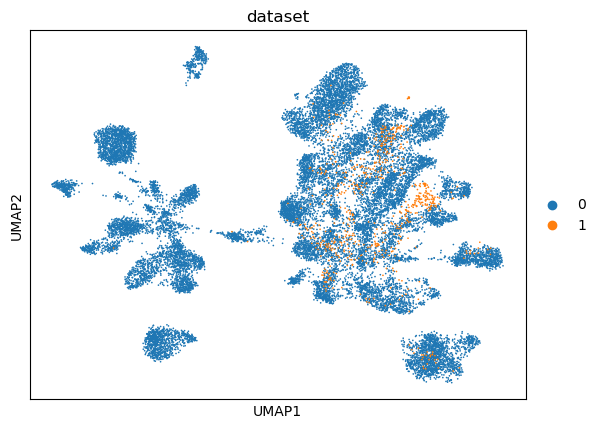

In [22]:
# UMAP visualization
sc.pp.neighbors(combined_data, use_rep='X_pca')
sc.tl.umap(combined_data)
sc.pl.umap(combined_data, color=['dataset'])


In [23]:
# Save the integrated data
save_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/integrated_BeatAML_vanGalen_data/'
combined_data.write(save_dir + 'integrated_data.h5ad')


In [25]:
#sc.tl.pca(combined_data, svd_solver='arpack')
#sc.pl.pca_variance_ratio(combined_data, log=True)  # To visualize the explained variance


In [26]:
#sc.pp.neighbors(combined_data, n_neighbors=10, n_pcs=40)  # Adjust n_neighbors and n_pcs as needed


/tmp/ipykernel_10335/1271497523.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(combined_data, resolution=0.50)  # Adjust resolution parameter as needed


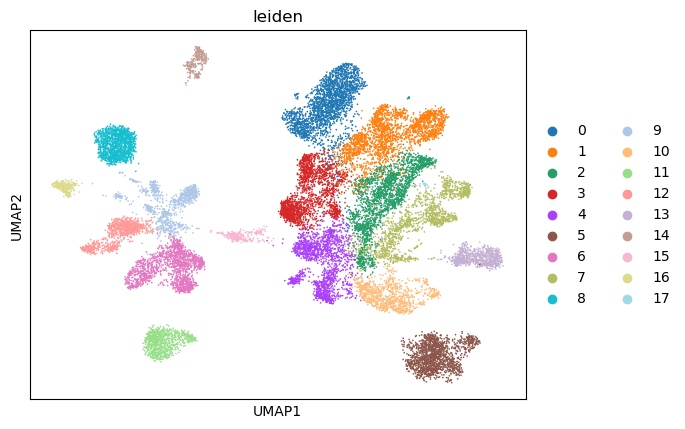

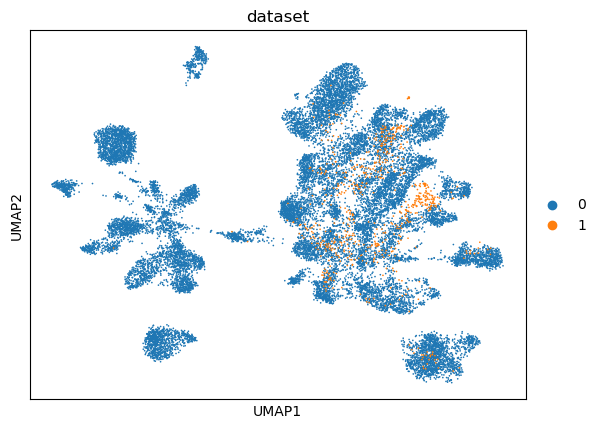

In [27]:
sc.tl.leiden(combined_data, resolution=0.50)  # Adjust resolution parameter as needed
sc.pl.umap(combined_data, color=['leiden'])  # UMAP visualization colored by cluster
sc.pl.umap(combined_data, color=['dataset'])


In [28]:
#sc.tl.umap(combined_data)
#sc.pl.umap(combined_data, color=['dataset', 'leiden'])  # Visualize clusters and datasets


In [29]:
#print(combined_data)


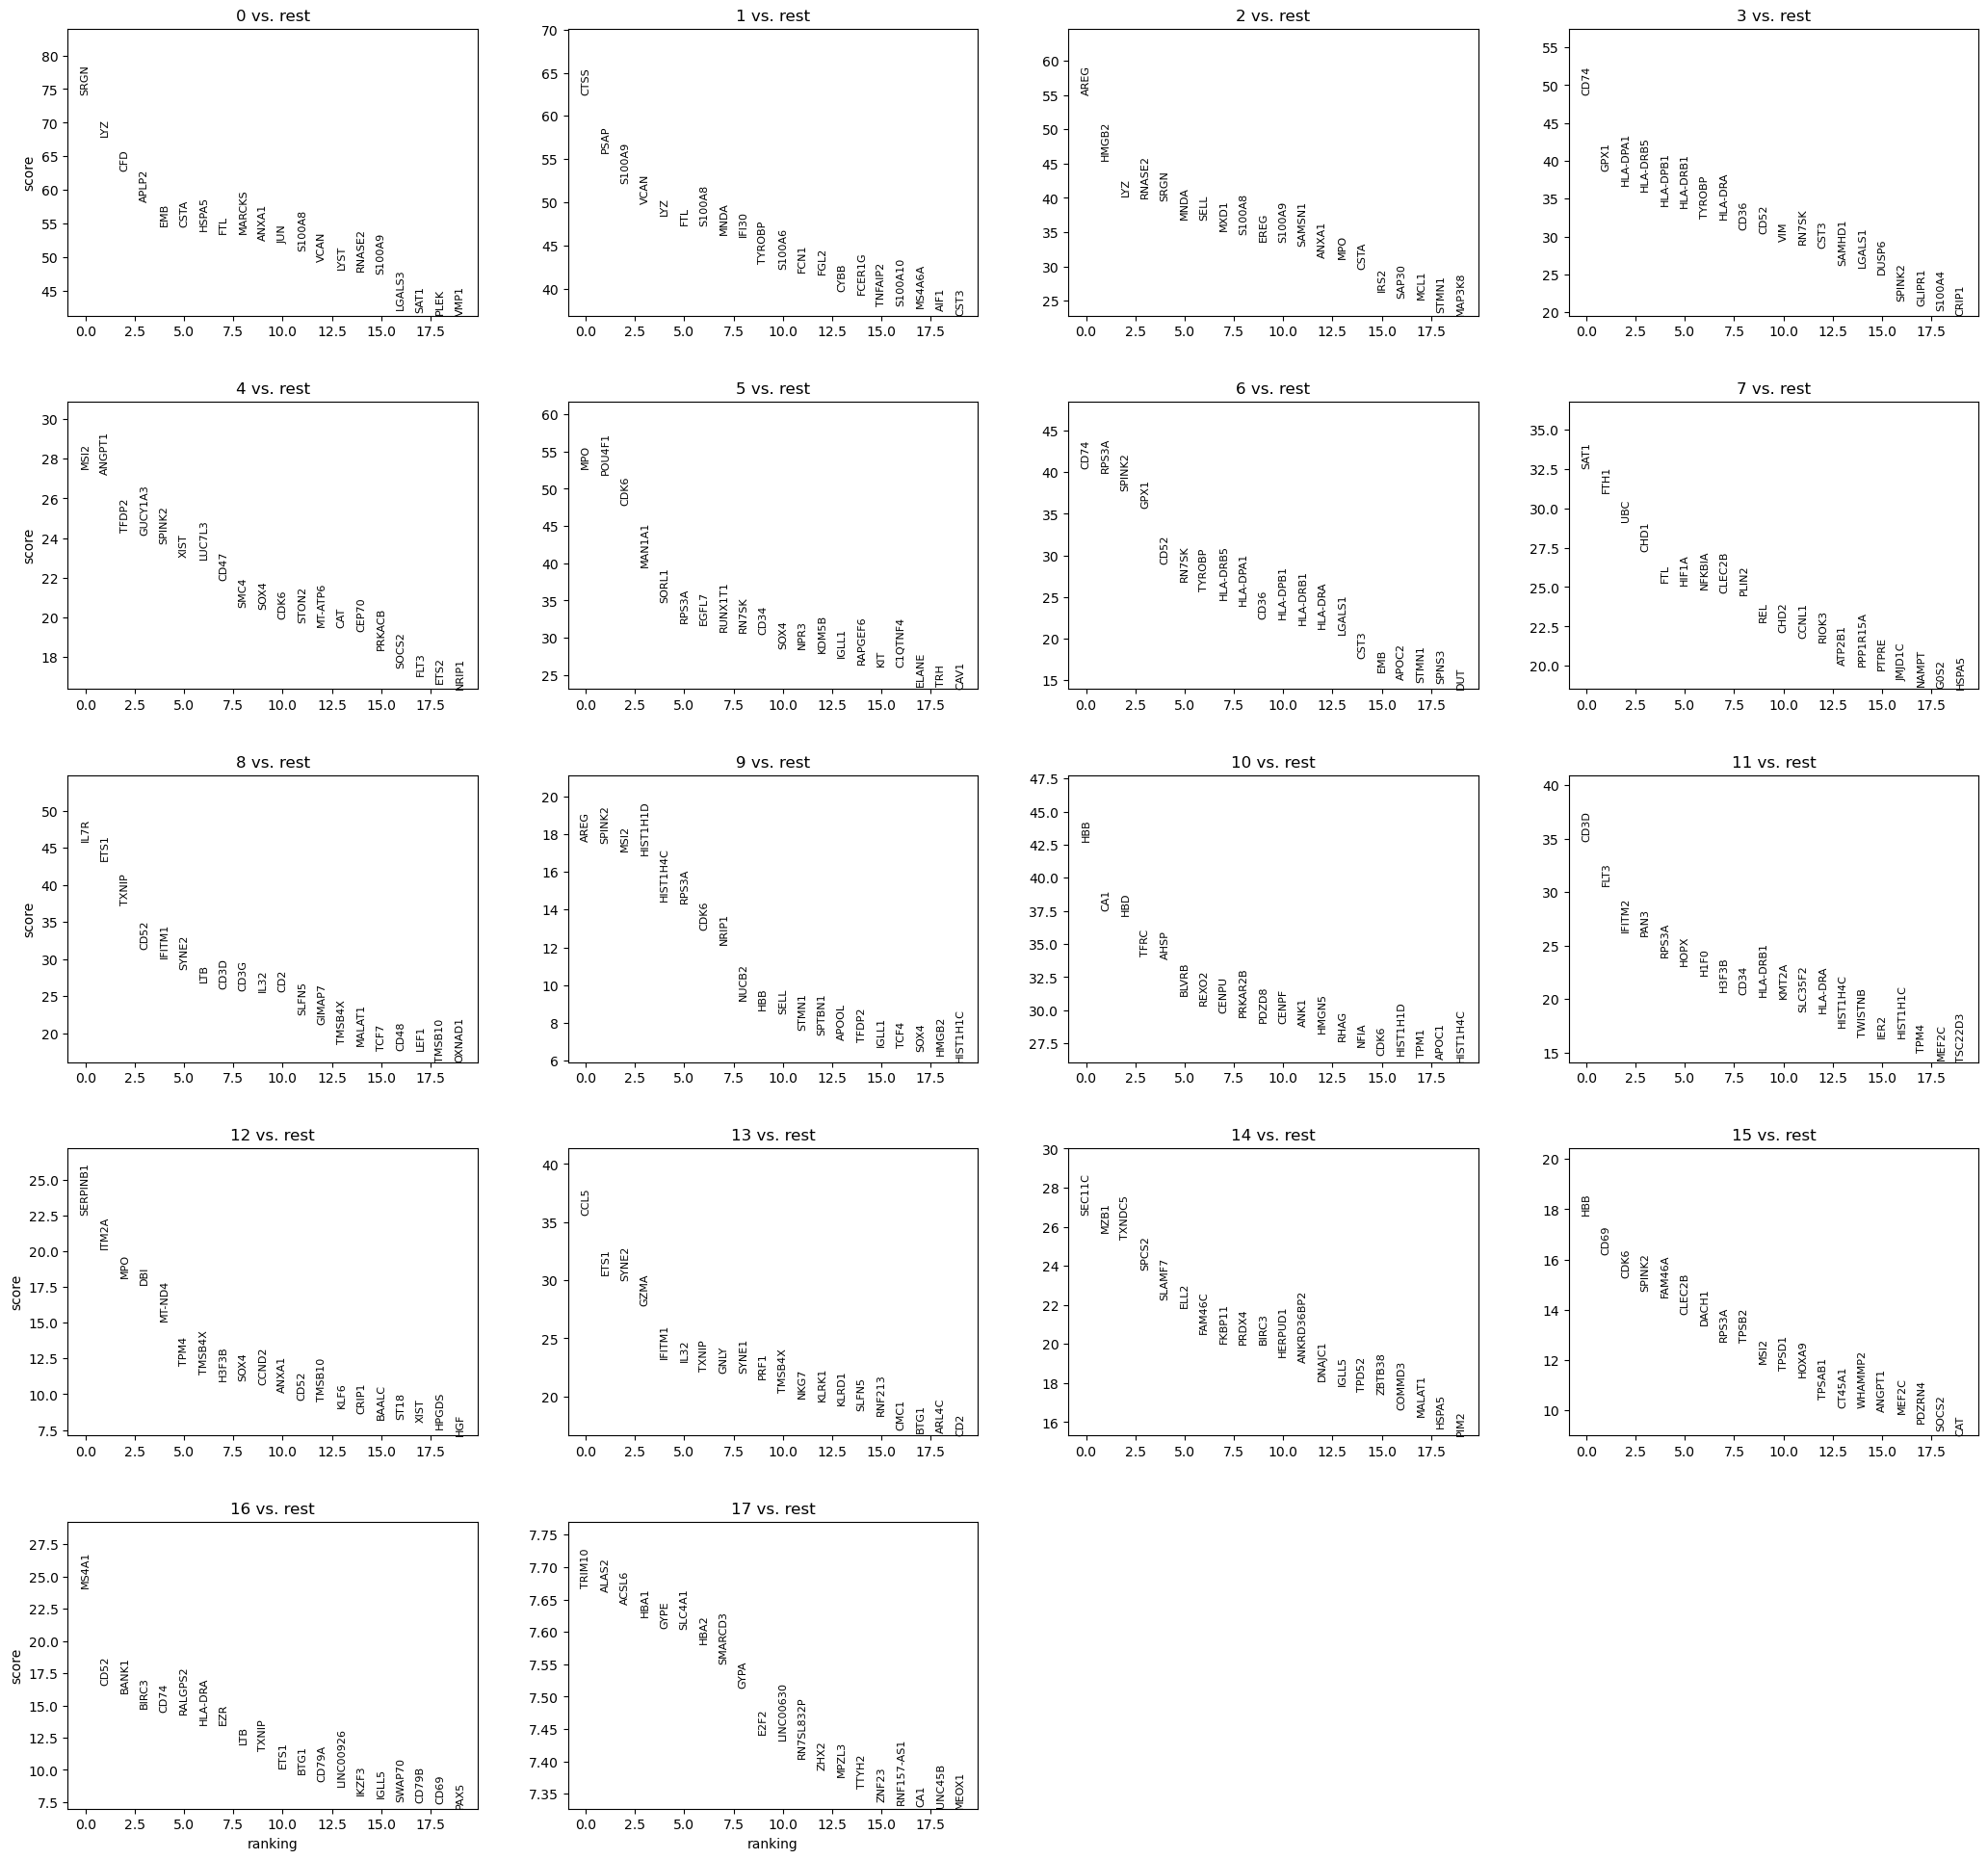

In [33]:
sc.tl.rank_genes_groups(combined_data, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(combined_data, n_genes=20, sharey=False)


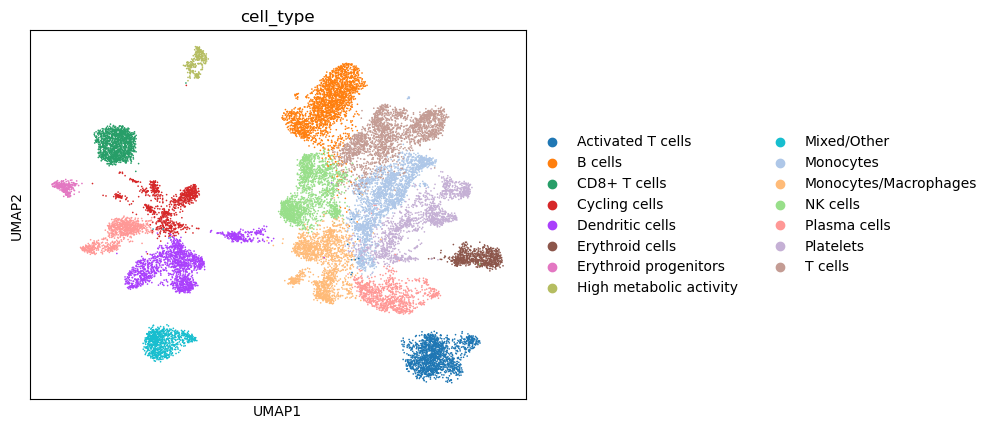

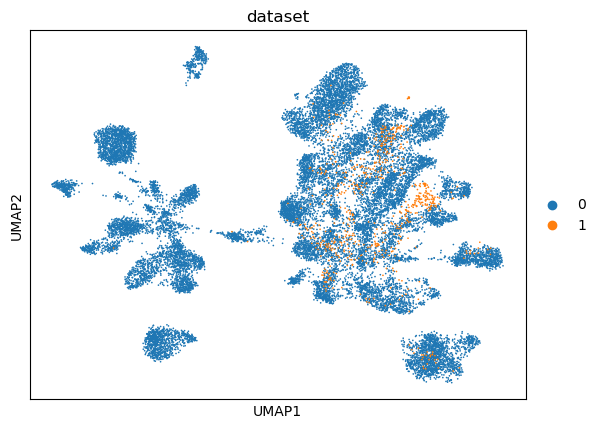

In [36]:
# Manually create a dictionary mapping cluster IDs to cell types based on marker genes
cluster_to_cell_type = {
    '0': 'B cells',
    '1': 'T cells',
    '2': 'Monocytes',
    '3': 'NK cells',
    '4': 'Monocytes/Macrophages',
    '5': 'Activated T cells',
    '6': 'Dendritic cells',
    '7': 'Platelets',
    '8': 'CD8+ T cells',
    '9': 'Cycling cells',
    '10': 'Plasma cells',
    '11': 'Mixed/Other',
    '12': 'Plasma cells',
    '13': 'Erythroid cells',
    '14': 'High metabolic activity',
    '15': 'Dendritic cells',
    '16': 'Erythroid progenitors',
    '17': 'Monocytes'
}

# Map the cluster IDs to cell types
combined_data.obs['cell_type'] = combined_data.obs['leiden'].map(cluster_to_cell_type)

# Plot UMAP with cell type annotations
sc.pl.umap(combined_data, color=['cell_type'])
sc.pl.umap(combined_data, color=['dataset'])


In [45]:
# Save the integrated data
save_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/integrated_BeatAML_vanGalen_data/'
combined_data.write(save_dir + 'integrated_data.h5ad')


In [31]:
print(combined_data.obsm['X_pca'])
print(len(combined_data.obsm['X_pca']))
print(combined_data.obsm['X_pca'].shape)

print(len(combined_data.X))
print(combined_data.X)
print(len(combined_data.X.shape))


[[-6.0987926  -1.1057144  -0.5044081  ... -1.2281008  -0.47310844
   0.07355709]
 [-0.5342561   2.3463624  -1.1147417  ...  0.4193456  -0.5533945
  -0.20487519]
 [-1.0809379   6.859812    1.1586998  ...  0.8209495  -0.9946214
   0.09837141]
 ...
 [ 9.949628    6.4872046   1.8372692  ... -0.17449379 -0.8752692
   0.7424649 ]
 [-6.0078807   8.165469    0.09494542 ... -0.32809666  0.0898541
   0.1838478 ]
 [-0.31397995  9.556315    5.5480475  ...  0.10253122  0.8230087
   0.3624488 ]]
21069
[[2.05803919e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.44460846e-03 4.93723666e-03 1.80221736e-01 ... 4.94822045e-04
  1.23659638e-03 3.21197533e-03]
 [7.77664781e-03 3.37730860e-03 3.44601274e-01 ... 0.00000000e+00
  3.37730860e-03 2.07969313e-03]
 [6.289

In [32]:
print(combined_data.obsm['X_umap'])


[[-1.7254809   0.45043615]
 [-3.2220788   0.01676821]
 [ 8.971851   -2.302619  ]
 ...
 [12.568916    6.0254817 ]
 [13.014483   -7.6255054 ]
 [ 8.800164   -1.8980856 ]]


In [44]:
print(combined_data)
print(combined_data.varm['PCs'])
print(combined_data.obsm['X_pca'])
print(combined_data.obs['cell_type'])
print(combined_data.obs['dataset'])


AnnData object with n_obs × n_vars = 21069 × 5668
    obs: 'dataset', 'leiden', 'cell_type'
    var: 'highly_variable', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    uns: 'pca', 'neighbors', 'umap', 'dataset_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
[[-1.36907314e-04 -3.89738427e-03  3.10371723e-03 ...  1.86735939e-03
   1.08019998e-02  8.34980456e-04]
 [-7.56975729e-04  1.62911182e-03 -2.55715277e-04 ...  8.61330249e-04
   2.40719222e-04 -1.15785352e-03]
 [ 1.61156785e-02  5.01701236e-03 -6.33066799e-03 ... -1.76519551e-03
   8.53348523e-03 -5.02575841e-03]
 ...
 [-1.50862224e-05  5.25722098e-05  9.35576754e-05 ...  9.55151845e-05
   1.94393782e-04 -3.44152329e-04]
 [-3.11977856e-05  4.94354208e-05 -9.72363068e-06 ...  1.33349431e-05
   7.11941102e-05 -3.00259650e-04]
 [-8.20188361e-05  1.68970655e-04  3.46905581

In [ ]:
# Might need to scale for model training later..
#sc.pp.scale(combined_data, max_value=10)

# Scale the PCA values? Is that a thing?
#sc.pp.scale(combined_data.obsm['X_pca'], max_value=10)
